In [1]:
# basic dependencies

import numpy as np
from numpy import loadtxt
from numpy import savetxt

import pandas as pd
import math
import time
import joblib

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

###########

# plotting dependencies
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# sk dependencies
import sklearn
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, WhiteKernel
from sklearn.linear_model import LinearRegression

# model evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict

In [2]:
cols = ['Styrene (mol %)', 'Myrcene (mol %)', 'DBI (mol %)', 'Temperature (degC)', 'AIBN (mol %)', 'Time (min)', 'Obj1 Sty%', 'Obj2 Tg']
df = pd.read_csv('batch1to4.csv', header=0, names=cols)
df

,Styrene (mol %),Myrcene (mol %),DBI (mol %),Temperature (degC),AIBN (mol %),Time (min),Obj1 Sty%,Obj2 Tg
0,35.410303,63.614810,0.974887,72.708350,4.089131,128.993385,25.616394,-43.13
1,38.607005,31.171948,30.221046,66.876865,2.992601,91.990623,29.951329,-17.33
2,70.546105,21.699958,7.753937,71.494711,0.604481,147.951340,64.000000,7.76
3,32.483981,47.606263,19.909756,62.353260,4.337932,268.693547,23.034840,-32.22
4,2.182698,47.833898,49.983404,60.887691,0.192883,227.404923,0.920789,-42.53
5,26.227406,3.214399,70.558195,73.615564,1.308430,298.860031,42.260961,12.76
6,46.493268,8.374224,45.132508,65.424515,3.355736,41.452220,58.351568,13.64
7,27.884902,56.712022,15.403076,69.485339,0.953466,351.240430,17.621145,-38.71
8,27.256287,28.335100,44.408614,64.019128,2.527522,381.235779,19.403347,-24.74
9,26.060638,39.625026,34.314336,78.693188,4.944340,438.392914,19.361084,-30.65


In [3]:
x_list = cols[0:5]
obj_list = cols[6:]
train_X = df[x_list].to_numpy()
train_y = df[obj_list].to_numpy()

xscaler = MinMaxScaler()
transformed_X = xscaler.fit_transform(train_X)

yscaler = MinMaxScaler() # we use this because it is easier to optimize on compared to power transform
transformed_y = yscaler.fit_transform(train_y)

In [36]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 1.00
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')

(-5.0, 95.0)

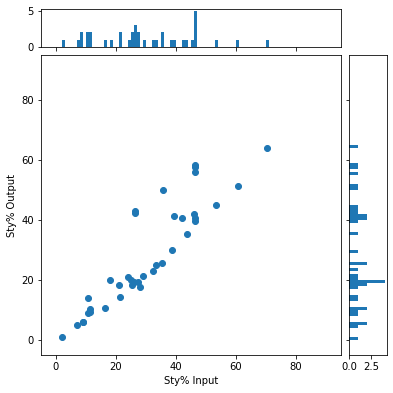

In [38]:
fig = plt.figure(figsize=(6, 6))

# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(8, 1), height_ratios=(1, 8),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# Draw the scatter plot and marginals.
scatter_hist(train_X[:,0], train_y[:,0], ax, ax_histx, ax_histy)

ax.set_xlabel('Sty% Input')
ax.set_ylabel('Sty% Output')

ax.set_xlim(-5.0, 95.0)
ax.set_ylim(-5.0, 95.0)

(-60.0, 40.0)

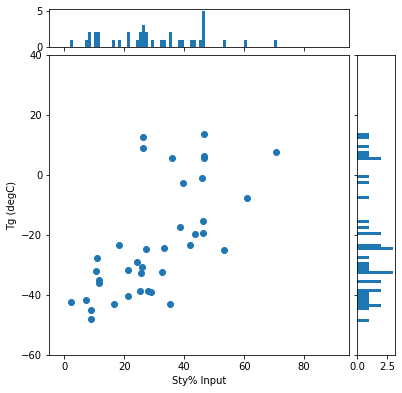

In [40]:
fig = plt.figure(figsize=(6, 6))

# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(8, 1), height_ratios=(1, 8),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# Draw the scatter plot and marginals.
scatter_hist(train_X[:,0], train_y[:,1], ax, ax_histx, ax_histy)

ax.set_xlabel('Sty% Input')
ax.set_ylabel('Tg (degC)')

ax.set_xlim(-5.0, 95.0)
ax.set_ylim(-60.0, 40.0)

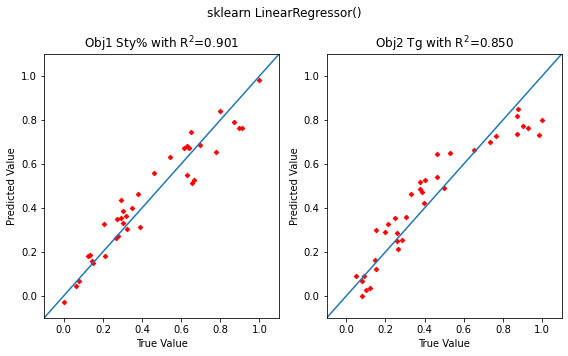

In [17]:
linear = LinearRegression()

y_pred = cross_val_predict(linear, transformed_X, transformed_y, cv=10)

fig, ax = plt.subplots(ncols = 2, figsize = (8,5))

for i in range(len(obj_list)):
    y_true = transformed_y[:,i]
    y_test = y_pred[:,i]


    ax[i].axline((1, 1), slope=1)

    r2 = metrics.r2_score(y_true, y_test)
    ax[i].scatter(x=y_true, y=y_test, #yerr=yerr, ls='', 
                  marker='D', s=10, c='r',
                  label='R$^2$={:.3f}'.format(r2),
                 )
    
    ax[i].set_title(obj_list[i]+' with R$^2$={:.3f}'.format(r2))
    ax[i].set_xlabel('True Value')
    ax[i].set_ylabel('Predicted Value')
    

    ax[i].set_xlim(-0.1, 1.1)
    ax[i].set_ylim(-0.1, 1.1)
    

fig.suptitle('sklearn LinearRegressor()')
fig.tight_layout()

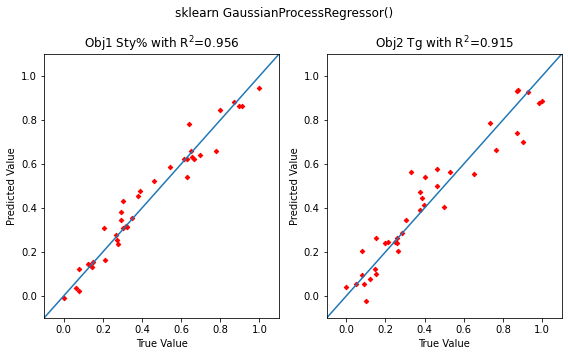

In [18]:
kernel = ConstantKernel(1.0, constant_value_bounds='fixed') * Matern(nu=2.5) + WhiteKernel(noise_level=1)
gpr = GaussianProcessRegressor(kernel=kernel, random_state=1, n_restarts_optimizer=10)

y_pred = cross_val_predict(gpr, transformed_X, transformed_y, cv=10)

fig, ax = plt.subplots(ncols = 2, figsize = (8,5))

for i in range(len(obj_list)):
    y_true = transformed_y[:,i]
    y_test = y_pred[:,i]

    ax[i].axline((1, 1), slope=1)

    r2 = metrics.r2_score(y_true, y_test)
    ax[i].scatter(x=y_true, y=y_test, #yerr=yerr, ls='', 
                  marker='D', s=10, c='r',
                  label='R$^2$={:.3f}'.format(r2),
                 )
    
    ax[i].set_title(obj_list[i]+' with R$^2$={:.3f}'.format(r2))
    ax[i].set_xlabel('True Value')
    ax[i].set_ylabel('Predicted Value')
    

    ax[i].set_xlim(-0.1, 1.1)
    ax[i].set_ylim(-0.1, 1.1)
    

fig.suptitle('sklearn GaussianProcessRegressor()')
fig.tight_layout()